In [1]:
# ==== Cell 1: setup & imports ====
import os, glob, random, itertools, tempfile, time
import numpy as np
import librosa
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# seeds
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

print("TF:", tf.__version__)
print("Keras (tf.keras):", keras.__version__)


TF: 2.16.1
Keras (tf.keras): 3.12.0


In [ ]:
# ==== Cell 2: config ====

DATASET_DIR = r"C:\Users\GALAXY COMPUTER\Downloads\emotion_try\emotion_try\Audio_Speech_Actors_01-24"
# RAVDESS map
RAVDESS_EMOTION_MAP = {
    "01": "neutral","02": "calm","03": "happy","04": "sad",
    "05": "angry","06": "fearful","07": "disgust","08": "surprised",
}

# 6-class target (merge neutral+calm, drop surprised)
TARGET_EMOTIONS = ["neutral", "happy", "sad", "angry", "fearful", "disgust"]

SAMPLE_RATE = 22050
DURATION = 3.0
SAMPLES_PER_TRACK = int(SAMPLE_RATE * DURATION)
N_MFCC = 60

actor_dirs = sorted(glob.glob(os.path.join(DATASET_DIR, "Actor_*")))
print(f"Found {len(actor_dirs)} actor folders.")


Found 24 actor folders.


In [3]:
# ==== Cell 3: features & augmentation ====
def load_fixed(path, sr=SAMPLE_RATE):
    sig, _ = librosa.load(path, sr=sr, mono=True)
    if len(sig) > SAMPLES_PER_TRACK:
        sig = sig[:SAMPLES_PER_TRACK]
    else:
        sig = np.pad(sig, (0, SAMPLES_PER_TRACK - len(sig)))
    return sig

def mfcc_from_sig(sig, sr=SAMPLE_RATE, n_mfcc=N_MFCC):
    return librosa.feature.mfcc(y=sig, sr=sr, n_mfcc=n_mfcc)  # (n_mfcc, time)

def add_noise(sig, noise_factor=0.01):
    return sig + noise_factor * np.random.randn(len(sig))

def pitch_up(sig, sr=SAMPLE_RATE, steps=2):
    return librosa.effects.pitch_shift(sig, sr=sr, n_steps=steps)

all_features, all_labels = [], []
EXTRA_AUG = {"sad", "fearful", "disgust"}

for actor_dir in actor_dirs:
    for wav_path in glob.glob(os.path.join(actor_dir, "*.wav")):
        parts = os.path.basename(wav_path).split("-")
        emotion = RAVDESS_EMOTION_MAP.get(parts[2], None)
        if emotion in ["neutral", "calm"]:
            emotion = "neutral"
        if emotion not in TARGET_EMOTIONS:
            continue

        # 1) original
        sig = load_fixed(wav_path)
        all_features.append(mfcc_from_sig(sig))
        all_labels.append(emotion)

        # 2) noisy
        sig_n = add_noise(sig)
        all_features.append(mfcc_from_sig(sig_n))
        all_labels.append(emotion)

        # 3) extra for rare classes
        if emotion in EXTRA_AUG:
            try:
                sig_p = pitch_up(sig)
                if len(sig_p) > SAMPLES_PER_TRACK:
                    sig_p = sig_p[:SAMPLES_PER_TRACK]
                else:
                    sig_p = np.pad(sig_p, (0, SAMPLES_PER_TRACK - len(sig_p)))
                all_features.append(mfcc_from_sig(sig_p))
                all_labels.append(emotion)
            except Exception:
                pass

print("Total samples after augmentation:", len(all_features))


Total samples after augmentation: 3072


In [4]:
# ==== Cell 4: arrays + split ====
X = np.array([f.T for f in all_features], dtype=np.float32)  # (N, time, 60)
le = LabelEncoder()
y = le.fit_transform(all_labels)
num_classes = len(le.classes_)

print("Classes:", le.classes_)
print("X shape:", X.shape, "y shape:", y.shape)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Classes: ['angry' 'disgust' 'fearful' 'happy' 'neutral' 'sad']
X shape: (3072, 130, 60) y shape: (3072,)
Train: (2150, 130, 60) Val: (461, 130, 60) Test: (461, 130, 60)


In [5]:
# ==== Cell 5: model (Conv1D -> Conv1D -> BiLSTM -> Attention -> Dense) ====

class SumContext(layers.Layer):
    """Time-wise weighted sum: sum_t (x_t * a_t)."""
    def call(self, inputs):
        x, attn = inputs  # x: (B,T,F), attn: (B,T,1)
        return tf.reduce_sum(x * attn, axis=1)  # (B,F)

    def get_config(self):
        return super().get_config()

inputs = keras.Input(shape=X_train.shape[1:])   # (time, features)

# Conv stack
x = layers.Conv1D(96, 5, padding="same", activation="relu")(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(2)(x)

x = layers.Conv1D(160, 3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(2)(x)

# BiLSTM (sequence output)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x = layers.Dropout(0.4)(x)

# Attention (Keras-native, no Lambda)
score = layers.Dense(1, activation="tanh")(x)                # (B,T,1)
attn  = layers.Softmax(axis=1, name="attn_weights")(score)   # (B,T,1)
context = SumContext(name="attn_context")([x, attn])         # (B,F)

# Classifier
x = layers.Dense(128, activation="relu")(context)
x = layers.Dropout(0.35)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs, name="ser_6class_attn")
model.summary()


Model: "ser_6class_attn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 130, 60)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 130, 96)   │     28,896 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 130, 96)   │        384 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 65, 96)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 65, 160)   │     46,240 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 65, 160)   │        640 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 32, 160)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 32, 256)   │    295,936 │ max_pooling1d_1[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 256)   │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32, 1)     │        257 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_weights        │ (None, 32, 1)     │          0 │ dense[0][0]       │
│ (Softmax)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_context        │ (None, 256)       │          0 │ dropout[0][0],    │
│ (SumContext)        │                   │            │ attn_weights[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ attn_context[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 6)         │        774 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 406,023 (1.55 MB)

 Trainable params: 405,511 (1.55 MB)

 Non-trainable params: 512 (2.00 KB)

In [6]:
# ==== Cell 6: train ====
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: w for i, w in enumerate(class_weights)}
print("Class weights:", class_weights)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(1e-3),
    metrics=["accuracy"],
)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=7, restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy", factor=0.5, patience=3, min_lr=1e-5, verbose=1
    )
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    class_weight=class_weights,
    verbose=1,
    callbacks=callbacks
)


Class weights: {0: 1.332094175960347, 1: 0.8891645988420182, 2: 0.8891645988420182, 3: 1.332094175960347, 4: 0.8891645988420182, 5: 0.8891645988420182}
Epoch 1/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 0.3977 - loss: 1.4719 - val_accuracy: 0.4490 - val_loss: 1.4080 - learning_rate: 0.0010
Epoch 2/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.5321 - loss: 1.1929 - val_accuracy: 0.4620 - val_loss: 1.4147 - learning_rate: 0.0010
Epoch 3/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.6214 - loss: 0.9867 - val_accuracy: 0.4642 - val_loss: 1.5939 - learning_rate: 0.0010
Epoch 4/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.6865 - loss: 0.8257 - val_accuracy: 0.4989 - val_loss: 1.5102 - learning_rate: 0.0010
Epoch 5/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.7405 - loss: 0.6866 - val_accuracy: 0.5575 - val_loss: 1.2223 - learning_rate: 0.0010
Epoch 6/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.7707 - loss: 0.5921 

Test accuracy: 77.01%
              precision    recall  f1-score   support

       angry       0.85      0.81      0.83        57
     disgust       0.82      0.80      0.81        86
     fearful       0.73      0.85      0.79        87
       happy       0.78      0.67      0.72        58
     neutral       0.83      0.79      0.81        87
         sad       0.65      0.67      0.66        86

    accuracy                           0.77       461
   macro avg       0.78      0.77      0.77       461
weighted avg       0.77      0.77      0.77       461



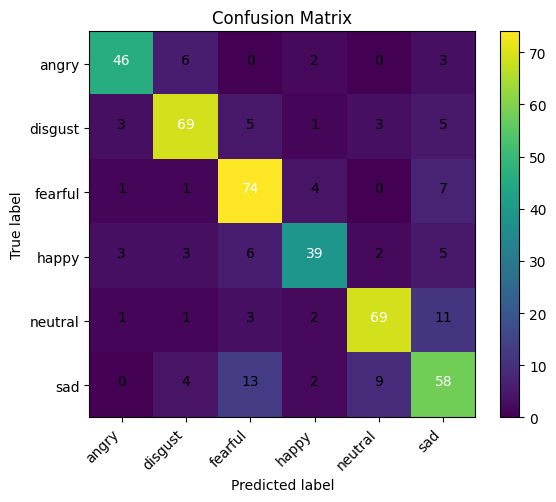

In [7]:
# ==== Cell 7: evaluate + confusion ====
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc*100:.2f}%")

y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
ticks = np.arange(len(le.classes_))
plt.xticks(ticks, le.classes_, rotation=45, ha="right")
plt.yticks(ticks, le.classes_)
thresh = cm.max()/2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout(); plt.show()


In [8]:
# ==== Cell 8: save baseline ====
os.makedirs("saved_models", exist_ok=True)
BASELINE_H5 = "saved_models/ser_baseline.h5"
model.save(BASELINE_H5)
print("Saved:", BASELINE_H5)


Saved: saved_models/ser_baseline.h5


In [9]:
# ==== Cell 9: pruning (magnitude) ====
PRUNE_SPARSITY = 0.50   # e.g., 0.3..0.6

PRUNABLE_TENSOR_SUFFIXES = (
    "kernel:0",             # Dense/Conv1D kernel
    "recurrent_kernel:0",   # LSTM recurrent
)

def build_masks_for_model(m, sparsity):
    masks = {}
    for v in m.weights:
        name = v.name
        if name.endswith(PRUNABLE_TENSOR_SUFFIXES):
            w = v.numpy()
            if w.size == 0: 
                continue
            thr = np.percentile(np.abs(w), sparsity*100.0)
            masks[name] = (np.abs(w) >= thr).astype(w.dtype)
    return masks

def apply_masks_to_model(m, masks):
    for v in m.weights:
        if v.name in masks:
            v.assign(v * masks[v.name])

# clone safely (model has only serializable layers now)
pruned_model = keras.models.clone_model(model)
pruned_model.build(model.input_shape)
pruned_model.set_weights(model.get_weights())

masks = build_masks_for_model(pruned_model, PRUNE_SPARSITY)
apply_masks_to_model(pruned_model, masks)

# light finetune to recover accuracy
pruned_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

class MaskEnforcer(keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        apply_masks_to_model(self.model, masks)

history_pruned = pruned_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=3, batch_size=32, verbose=1,
    callbacks=[MaskEnforcer()]
)

PRUNED_H5 = "saved_models/ser_pruned_manual.h5"
pruned_model.save(PRUNED_H5)
print("Saved:", PRUNED_H5)


Epoch 1/3


68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - accuracy: 0.9963 - loss: 0.0116 - val_accuracy: 0.7354 - val_loss: 1.1893
Epoch 2/3
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9981 - loss: 0.0096 - val_accuracy: 0.7354 - val_loss: 1.2877
Epoch 3/3
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9986 - loss: 0.0076 - val_accuracy: 0.7440 - val_loss: 1.2358


Saved: saved_models/ser_pruned_manual.h5


In [10]:
# ==== Cell 10: Robust TFLite export (with fallbacks) ====
import numpy as np, os, tempfile, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

os.makedirs("saved_models", exist_ok=True)
TFLITE_FP = "saved_models/ser_6class_unrolled.tflite"

# --- 1) Make a TFLite-friendly clone (unroll LSTMs, implementation=2) ---
def clone_with_unrolled_lstm(src):
    def clone_fn(layer):
        if isinstance(layer, layers.LSTM):
            cfg = layer.get_config()
            cfg["unroll"] = True
            cfg["implementation"] = 2  # matmul-based
            return layers.LSTM.from_config(cfg)
        if isinstance(layer, layers.Bidirectional):
            fw = layer.forward_layer; bw = layer.backward_layer
            if isinstance(fw, layers.LSTM) and isinstance(bw, layers.LSTM):
                fw_cfg = fw.get_config(); fw_cfg["unroll"]=True; fw_cfg["implementation"]=2
                bw_cfg = bw.get_config(); bw_cfg["unroll"]=True; bw_cfg["implementation"]=2
                new_fw = layers.LSTM.from_config(fw_cfg)
                new_bw = layers.LSTM.from_config(bw_cfg)
                wrap_cfg = layer.get_config()
                return layers.Bidirectional(
                    new_fw,
                    backward_layer=new_bw,
                    merge_mode=wrap_cfg.get("merge_mode", "concat"),
                    name=wrap_cfg.get("name", None)
                )
        return layer

    m2 = keras.models.clone_model(src, clone_function=clone_fn)
    m2.build(src.input_shape)
    m2.set_weights(src.get_weights())
    return m2

friendly = clone_with_unrolled_lstm(model)

# --- 2) Export a concrete function (stable on Windows) ---
input_shape_wo_batch = friendly.inputs[0].shape[1:]  # (T, F)
spec = tf.TensorSpec(shape=[1, *input_shape_wo_batch], dtype=tf.float32)

@tf.function
def serving_fn(x):
    return friendly(x, training=False)

concrete = serving_fn.get_concrete_function(spec)

# --- 3) Conversion helpers with safe fallbacks ---
def try_convert(converter_setup, out_path):
    converter = converter_setup()
    tflite_bytes = converter.convert()
    with open(out_path, "wb") as f:
        f.write(tflite_bytes)
    return out_path

def make_converter_fp16():
    conv = tf.lite.TFLiteConverter.from_concrete_functions([concrete])
    conv.optimizations = [tf.lite.Optimize.DEFAULT]
    conv.target_spec.supported_types = [tf.float16]              # weight fp16
    conv.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
    conv._experimental_lower_tensor_list_ops = False
    conv.experimental_enable_resource_variables = True
    conv.experimental_new_converter = True
    return conv

def make_converter_dynamic_range():
    conv = tf.lite.TFLiteConverter.from_concrete_functions([concrete])
    conv.optimizations = [tf.lite.Optimize.DEFAULT]              # dynamic-range (weight-only int8)
    conv.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
    conv._experimental_lower_tensor_list_ops = False
    conv.experimental_enable_resource_variables = True
    conv.experimental_new_converter = True
    return conv

def make_converter_select_tf_ops():
    # Last resort: allow Select TF ops
    conv = tf.lite.TFLiteConverter.from_concrete_functions([concrete])
    conv.optimizations = [tf.lite.Optimize.DEFAULT]
    conv.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS,
    ]
    conv._experimental_lower_tensor_list_ops = False
    conv.experimental_enable_resource_variables = True
    conv.experimental_new_converter = True
    return conv

# --- 4) Try FP16 -> Dynamic Range -> Select TF Ops ---
converted_path = None
for maker, label in [
    (make_converter_fp16,        "FP16"),
    (make_converter_dynamic_range,"Dynamic-Range INT8 (weights)"),
    (make_converter_select_tf_ops,"Select TF Ops fallback"),
]:
    try:
        converted_path = try_convert(maker, TFLITE_FP)
        print(f"✅ TFLite ({label}) saved to:", converted_path)
        break
    except Exception as e:
        print(f"⚠️ {label} conversion failed, trying next option...\n   Reason: {e}")

if converted_path is None:
    raise RuntimeError("TFLite conversion failed for all strategies.")


✅ TFLite (FP16) saved to: saved_models/ser_6class_unrolled.tflite


In [11]:
# ==== Cell 11: evaluation & benchmarking ====
import pandas as pd

def model_size_mb_keras(m):
    with tempfile.NamedTemporaryFile(suffix=".h5", delete=False) as f:
        path = f.name
    try:
        m.save(path)
        return round(os.path.getsize(path)/(1024*1024), 3)
    finally:
        try: os.remove(path)
        except: pass

def file_mb(path): 
    return round(os.path.getsize(path)/(1024*1024), 3)

def eval_keras(m, X, y, name):
    y_pred = np.argmax(m.predict(X, verbose=0), axis=1)
    acc = float(accuracy_score(y, y_pred))
    lat=[]
    for i in range(len(X)):
        t0=time.perf_counter(); _=m.predict(X[i:i+1], verbose=0)
        lat.append((time.perf_counter()-t0)*1000.0)
    return {
        "Model":name, "Format":".h5", "Size (MB)":model_size_mb_keras(m),
        "Accuracy":round(acc,4),
        "Latency mean (ms)":round(float(np.mean(lat)),2),
        "Latency p50 (ms)":round(float(np.median(lat)),2),
        "Latency p95 (ms)":round(float(np.percentile(lat,95)),2),
    }, y_pred

def eval_tflite(path, X, y, name):
    interpreter = tf.lite.Interpreter(model_path=path)
    interpreter.allocate_tensors()
    in_det  = interpreter.get_input_details()
    out_det = interpreter.get_output_details()

    # Expect (1, T, F)
    _, ih, iw = in_det[0]["shape"]
    y_preds, lat = [], []
    for i in range(len(X)):
        arr = X[i]
        # resize if needed (linear interpolation along time)
        if arr.shape != (ih, iw):
            # simple 2D resize
            t_old = np.linspace(0.0, 1.0, arr.shape[0], dtype=np.float32)
            t_new = np.linspace(0.0, 1.0, ih, dtype=np.float32)
            tmp = np.empty((ih, arr.shape[1]), dtype=np.float32)
            for j in range(arr.shape[1]):
                tmp[:, j] = np.interp(t_new, t_old, arr[:, j])
            f_old = np.linspace(0.0, 1.0, arr.shape[1], dtype=np.float32)
            f_new = np.linspace(0.0, 1.0, iw, dtype=np.float32)
            arr_res = np.empty((ih, iw), dtype=np.float32)
            for r in range(ih):
                arr_res[r, :] = np.interp(f_new, f_old, tmp[r, :])
            arr = arr_res

        sample = arr[np.newaxis, ...].astype(np.float32)  # float I/O
        try:
            interpreter.resize_tensor_input(in_det[0]["index"], sample.shape, strict=False)
        except Exception:
            pass
        interpreter.allocate_tensors()
        in_det  = interpreter.get_input_details()
        out_det = interpreter.get_output_details()

        interpreter.set_tensor(in_det[0]["index"], sample)
        t0=time.perf_counter(); interpreter.invoke()
        lat.append((time.perf_counter()-t0)*1000.0)

        out = interpreter.get_tensor(out_det[0]["index"])
        y_preds.append(int(np.argmax(out, axis=-1).squeeze()))

    acc = float(accuracy_score(y, y_preds))
    return {
        "Model":name, "Format":".tflite", "Size (MB)":file_mb(path),
        "Accuracy":round(acc,4),
        "Latency mean (ms)":round(float(np.mean(lat)),2),
        "Latency p50 (ms)":round(float(np.median(lat)),2),
        "Latency p95 (ms)":round(float(np.percentile(lat,95)),2),
    }, np.array(y_preds)

results, pred_store = [], {}

r, yp = eval_keras(model, X_test, y_test, "Baseline")
results.append(r); pred_store["Baseline"]=yp

r, yp = eval_keras(pruned_model, X_test, y_test, "Pruned")
results.append(r); pred_store["Pruned"]=yp

r, yp = eval_tflite(TFLITE_FP, X_test, y_test, "Quantized-INT8")
results.append(r); pred_store["Quantized-INT8"]=yp

df = pd.DataFrame(results, columns=[
    "Model","Format","Size (MB)","Accuracy","Latency mean (ms)","Latency p50 (ms)","Latency p95 (ms)"
]).sort_values(by=["Format","Model"]).reset_index(drop=True)

print("\n=== Baseline vs Pruned vs Quantized (Accuracy / Size / Latency) ===")
display(df)

for name, ypred in pred_store.items():
    print(f"\n--- Classification Report: {name} ---")
    print(classification_report(y_test, ypred, target_names=le.classes_, digits=3))



=== Baseline vs Pruned vs Quantized (Accuracy / Size / Latency) ===


,Model,Format,Size (MB),Accuracy,Latency mean (ms),Latency p50 (ms),Latency p95 (ms)
0,Baseline,.h5,4.725,0.7701,121.56,116.99,154.60
1,Pruned,.h5,4.727,0.7722,122.18,116.68,151.00
2,Quantized-INT8,.tflite,0.970,0.7701,5.01,4.59,6.93



--- Classification Report: Baseline ---
              precision    recall  f1-score   support

       angry      0.852     0.807     0.829        57
     disgust      0.821     0.802     0.812        86
     fearful      0.733     0.851     0.787        87
       happy      0.780     0.672     0.722        58
     neutral      0.831     0.793     0.812        87
         sad      0.652     0.674     0.663        86

    accuracy                          0.770       461
   macro avg      0.778     0.767     0.771       461
weighted avg      0.773     0.770     0.770       461


--- Classification Report: Pruned ---
              precision    recall  f1-score   support

       angry      0.833     0.789     0.811        57
     disgust      0.791     0.837     0.814        86
     fearful      0.758     0.828     0.791        87
       happy      0.769     0.690     0.727        58
     neutral      0.846     0.759     0.800        87
         sad      0.670     0.709     0.689        8